In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array  # Correct imports for image processing
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import (
    EfficientNetB3,
    ResNet50,
    DenseNet121,
    MobileNetV2,
    VGG16
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Scikit-learn Libraries for Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
print("GPU Available:", tf.test.is_gpu_available())

GPU Available: True



<div style="
    background: linear-gradient(to right, #f7f8fa, #e6f2ff); 
    color: #333; 
    border-radius: 15px; 
    text-align: center; 
    font-size: 20px; 
    padding: 25px; 
    border: 2px solid #ff4d4d; 
    width: 95%; 
    margin: 30px auto; 
    box-shadow: 0 6px 12px rgba(0, 0, 0, 0.2), 0 0 15px rgba(255, 77, 77, 0.5); 
    transition: all 0.3s ease-in-out;">
    <h1 style="font-size: 28px; margin: 0; font-family: 'Arial', sans-serif;">
        <span style="
            color: #ff3333; 
            font-weight: bold; 
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);">
            Load Dataset
        </span>
    </h1>
</div>

<style>
    div:hover {
        transform: scale(1.03); /* Slight zoom on hover */
        box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3), 0 0 20px rgba(255, 77, 77, 0.7);
    }
</style>

In [16]:
# Dataset paths
data_dir = "/kaggle/input/animal/Dataset"
train_dir = "/kaggle/input/animal/Dataset/train"
val_dir = "/kaggle/input/animal/Dataset/val"
test_dir = "/kaggle/input/animal/Dataset/test"

# Image dimensions and batch size
img_size = (224, 224)
batch_size = 32

Found 1027 images belonging to 3 classes.
Found 378 images belonging to 3 classes.
Found 358 images belonging to 3 classes.
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 663ms/step - accuracy: 0.3802 - loss: 1.5835 - val_accuracy: 0.7143 - val_loss: 1.0583
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 618ms/step - accuracy: 0.3877 - loss: 1.0950 - val_accuracy: 0.7116 - val_loss: 0.9366
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 652ms/step - accuracy: 0.4006 - loss: 1.0961 - val_accuracy: 0.6984 - val_loss: 1.0137
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 621ms/step - accuracy: 0.4569 - loss: 1.0735 - val_accuracy: 0.7143 - val_loss: 1.0207
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - accuracy: 0.4078 - loss: 1.0839 - val_accuracy: 0.6931 - val_loss: 0.9059
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 611ms/step - accuracy: 0.4077 - loss: 1.0779 - val_accuracy: 0.6984 - val_loss: 1.0052
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 630ms/step - accuracy: 0.4497 - loss: 1.0735 - val_accuracy:

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [ ]:
# Load training, validation, and test data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="sparse",  # Use sparse labels
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="sparse",
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="sparse",
)

<div style="
    background: linear-gradient(to right, #f7f8fa, #e6f2ff); 
    color: #333; 
    border-radius: 15px; 
    text-align: center; 
    font-size: 20px; 
    padding: 25px; 
    border: 2px solid #ff4d4d; 
    width: 95%; 
    margin: 30px auto; 
    box-shadow: 0 6px 12px rgba(0, 0, 0, 0.2), 0 0 15px rgba(255, 77, 77, 0.5); 
    transition: all 0.3s ease-in-out;">
    <h1 style="font-size: 28px; margin: 0; font-family: 'Arial', sans-serif;">
        <span style="
            color: #ff3333; 
            font-weight: bold; 
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);">
            CNN Model Architecture
        </span>
    </h1>
</div>

<style>
    div:hover {
        transform: scale(1.03); /* Slight zoom on hover */
        box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3), 0 0 20px rgba(255, 77, 77, 0.7);
    }
</style>

In [ ]:
# **Custom CNN Model**
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')  # Match number of classes
])

# Compile the model
custom_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history_custom = custom_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

In [ ]:
# **Pretrained MobileNetV2**
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

# Define Pre-trained Model
pretrained_model = Model(inputs=base_model.input, outputs=output)

# Compile Pre-trained Model
pretrained_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Pre-trained Model
history_pretrained = pretrained_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

In [ ]:

# Fine-tune the Model
base_model.trainable = True
pretrained_model.compile(optimizer=Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_finetune = pretrained_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

# Evaluate on Test Data
test_loss, test_accuracy = pretrained_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

### Model Evaluation

In [20]:
# Evaluate Custom CNN
custom_test_loss, custom_test_acc = custom_model.evaluate(test_data)
print(f"Custom CNN - Test Accuracy: {custom_test_acc * 100:.2f}%")

# Evaluate Pre-trained Model
pretrained_test_loss, pretrained_test_acc = pretrained_model.evaluate(test_data)
print(f"Pre-trained Model - Test Accuracy: {pretrained_test_acc * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.7033 - loss: 0.8619
Custom CNN - Test Accuracy: 69.55%
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.9833 - loss: 0.0407
Pre-trained Model - Test Accuracy: 98.04%


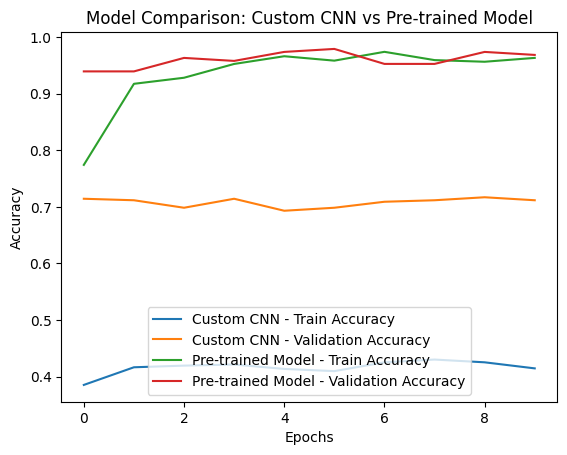

In [18]:
# Plot Training and Validation Accuracy
plt.plot(history_custom.history["accuracy"], label="Custom CNN - Train Accuracy")
plt.plot(history_custom.history["val_accuracy"], label="Custom CNN - Validation Accuracy")
plt.plot(history_pretrained.history["accuracy"], label="Pre-trained Model - Train Accuracy")
plt.plot(history_pretrained.history["val_accuracy"], label="Pre-trained Model - Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Comparison: Custom CNN vs Pre-trained Model")
plt.show()

### Confusion Matrix and Classification Report

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generate predictions for test data
custom_predictions = np.argmax(custom_model.predict(test_data), axis=1)
pretrained_predictions = np.argmax(pretrained_model.predict(test_data), axis=1)

# Get true labels
true_labels = test_data.classes

# Confusion Matrix
custom_confusion = confusion_matrix(true_labels, custom_predictions)
pretrained_confusion = confusion_matrix(true_labels, pretrained_predictions)
print("Custom Model Confusion Matrix:\n", custom_confusion)
print("Pretrained Model Confusion Matrix:\n", pretrained_confusion)

# Classification Report
custom_report = classification_report(true_labels, custom_predictions, target_names=test_data.class_indices.keys())
pretrained_report = classification_report(true_labels, pretrained_predictions, target_names=test_data.class_indices.keys())
print("Custom Model Classification Report:\n", custom_report)
print("Pretrained Model Classification Report:\n", pretrained_report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step
Custom Model Confusion Matrix:
 [[  0  65   1]
 [  1 239  10]
 [  1  37   4]]
Pretrained Model Confusion Matrix:
 [[ 13  46   7]
 [ 52 171  27]
 [  8  27   7]]
Custom Model Classification Report:
               precision    recall  f1-score   support

         cat       0.00      0.00      0.00        66
         dog       0.70      0.96      0.81       250
       horse       0.27      0.10      0.14        42

    accuracy                           0.68       358
   macro avg       0.32      0.35      0.32       358
weighted avg       0.52      0.68      0.58       358

Pretrained Model Classification Report:
               precision    recall  f1-score   support

         cat       0.18      0.20      0.19        66
         dog       0.70      0.68      0.69       250
       horse       0.17      0.17      0.17        42

    accuracy                           0.53       358
   macro avg       0.35    

### Visualization

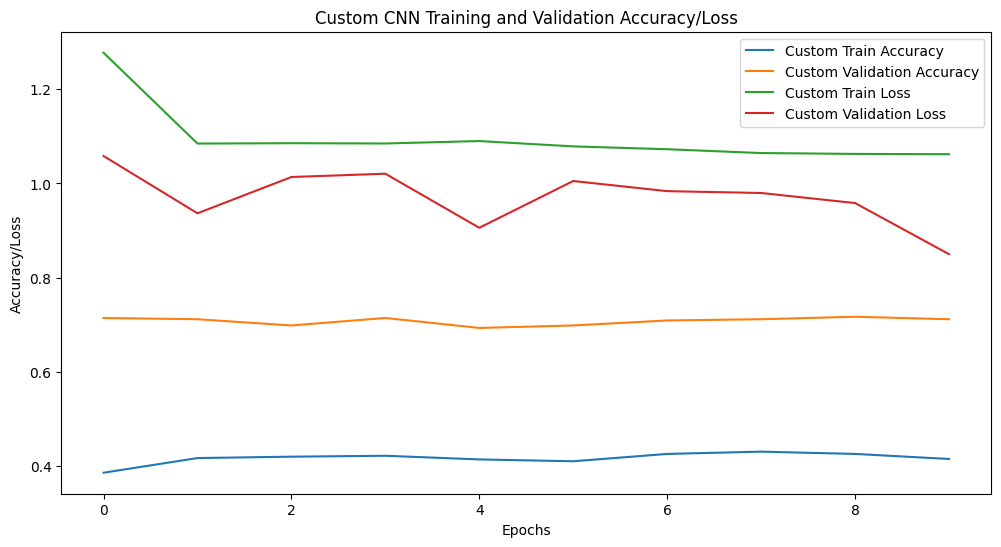

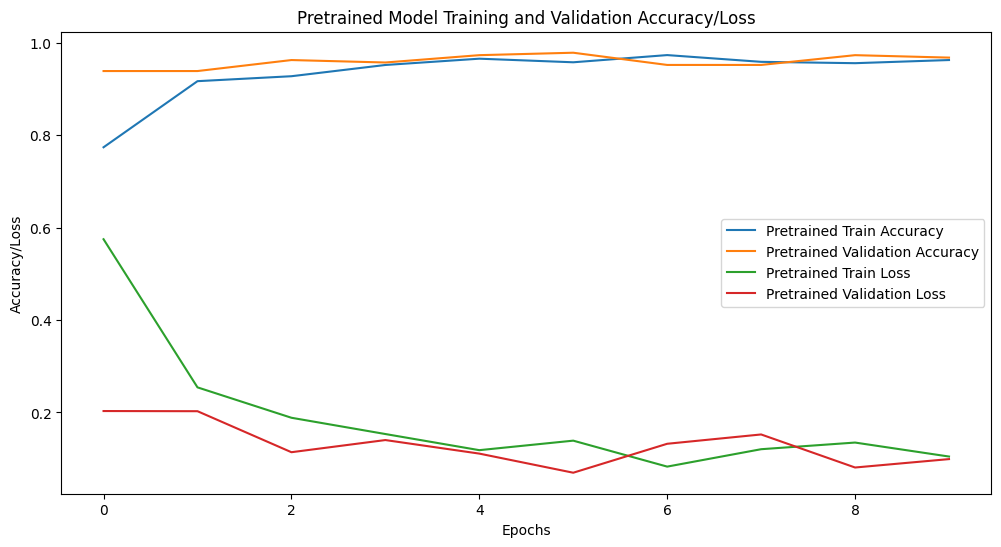

In [22]:
# Plot Training History for Custom Model
plt.figure(figsize=(12, 6))
plt.plot(history_custom.history['accuracy'], label='Custom Train Accuracy')
plt.plot(history_custom.history['val_accuracy'], label='Custom Validation Accuracy')
plt.plot(history_custom.history['loss'], label='Custom Train Loss')
plt.plot(history_custom.history['val_loss'], label='Custom Validation Loss')
plt.title('Custom CNN Training and Validation Accuracy/Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

# Plot Training History for Pretrained Model
plt.figure(figsize=(12, 6))
plt.plot(history_pretrained.history['accuracy'], label='Pretrained Train Accuracy')
plt.plot(history_pretrained.history['val_accuracy'], label='Pretrained Validation Accuracy')
plt.plot(history_pretrained.history['loss'], label='Pretrained Train Loss')
plt.plot(history_pretrained.history['val_loss'], label='Pretrained Validation Loss')
plt.title('Pretrained Model Training and Validation Accuracy/Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

### Original and Augmented Images

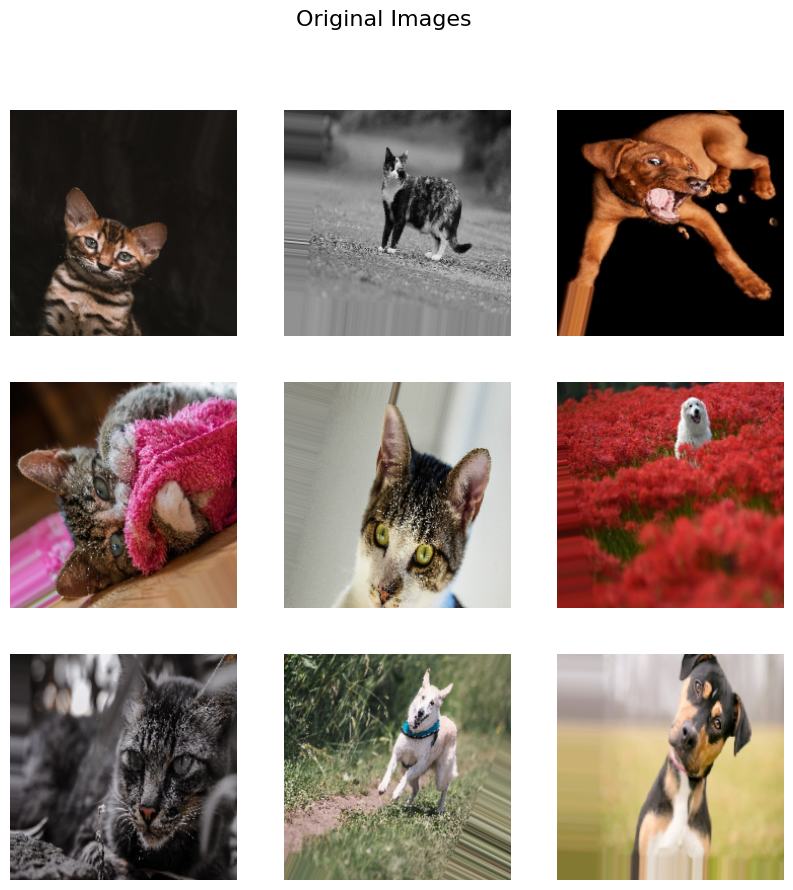

In [24]:
# Display some original images
for batch in train_data:
    images, labels = batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle("Original Images", fontsize=16)
    plt.show()
    break

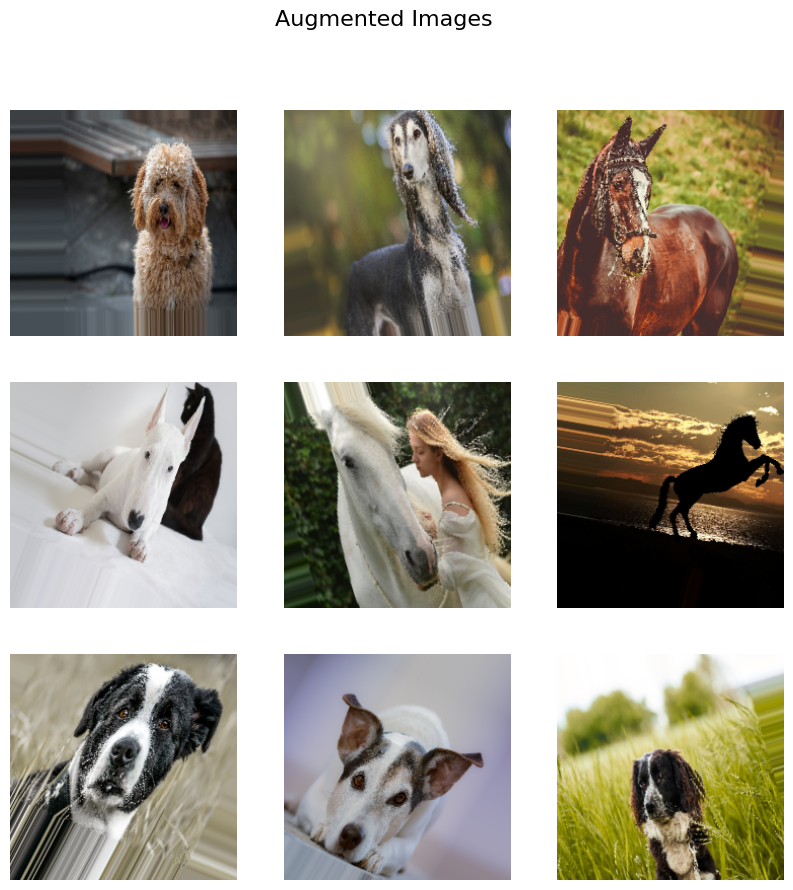

In [25]:
# Display some augmented images
for batch in train_data:
    images, labels = batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle("Augmented Images", fontsize=16)
    plt.show()
    break